<a href="https://colab.research.google.com/github/RaoSharjeelKhan/Machine-Learning/blob/main/Natural_Language_Processing_with_Disaster_Tweets_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from zipfile import ZipFile
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [4]:
# configuring the path of Kaggle.json file
!pip install kaggle
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# Kaggle api 
!kaggle competitions download -c nlp-getting-started

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 593k/593k [00:00<00:00, 1.36MB/s]
100% 593k/593k [00:00<00:00, 1.36MB/s]


In [5]:
DT='/content/nlp-getting-started.zip'
with ZipFile(DT, 'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [6]:
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')
df_sub=pd.read_csv('sample_submission.csv')
print('Shape of training dataset= {}        Shape of testing dataset= {}'.format(df_train.shape,df_test.shape))
print('-----'*19)
df_train.head()

Shape of training dataset= (7613, 5)        Shape of testing dataset= (3263, 4)
-----------------------------------------------------------------------------------------------


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

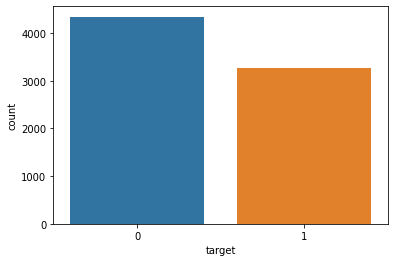

In [10]:
sns.countplot(data=df_train,x=df_train.target)

In [11]:
# Location column will not have that much impact on the target column, so lets just remove that column from both train and test dataset
df_train=df_train.drop(['id','location'],axis=1) 
df_test=df_test.drop('location',axis=1) 

In [12]:
df_train=df_train.dropna()
#df_test=df_test.dropna()
df_train.isnull().sum(),df_test.isnull().sum()

(keyword    0
 text       0
 target     0
 dtype: int64, id          0
 keyword    26
 text        0
 dtype: int64)

In [13]:
df_train['text_1'] = df_train['text'].str.replace('\d+', '')
df_test['text_1'] = df_test['text'].str.replace('\d+', '')
df_train.head(14)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,keyword,text,target,text_1
31,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,@bbcmtd Wholesale Markets ablaze http://t.co/l...
32,ablaze,We always try to bring the heavy. #metal #RT h...,0,We always try to bring the heavy. #metal #RT h...
33,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,#AFRICANBAZE: Breaking news:Nigeria flag set a...
34,ablaze,Crying out for more! Set me ablaze,0,Crying out for more! Set me ablaze
35,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...
36,ablaze,@PhDSquares #mufc they've built so much hype a...,0,@PhDSquares #mufc they've built so much hype a...
37,ablaze,INEC Office in Abia Set Ablaze - http://t.co/3...,1,INEC Office in Abia Set Ablaze - http://t.co/I...
38,ablaze,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...,1,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...
39,ablaze,Ablaze for you Lord :D,0,Ablaze for you Lord :D
40,ablaze,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,Check these out: http://t.co/rOINSmEJJ http://...


In [14]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
   return [lemmatizer.lemmatize(w,'v') for w in w_tokenizer.tokenize(text)]
df_train['text_2'] =df_train.text_1.apply(lemmatize_text)
df_test['text_2'] = df_test.text_1.apply(lemmatize_text)
df_train.head(15)


,keyword,text,target,text_1,text_2
31,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,@bbcmtd Wholesale Markets ablaze http://t.co/l...,"[@bbcmtd, Wholesale, Markets, ablaze, http://t..."
32,ablaze,We always try to bring the heavy. #metal #RT h...,0,We always try to bring the heavy. #metal #RT h...,"[We, always, try, to, bring, the, heavy., #met..."
33,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,#AFRICANBAZE: Breaking news:Nigeria flag set a...,"[#AFRICANBAZE:, Breaking, news:Nigeria, flag, ..."
34,ablaze,Crying out for more! Set me ablaze,0,Crying out for more! Set me ablaze,"[Crying, out, for, more!, Set, me, ablaze]"
35,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,"[On, plus, side, LOOK, AT, THE, SKY, LAST, NIG..."
36,ablaze,@PhDSquares #mufc they've built so much hype a...,0,@PhDSquares #mufc they've built so much hype a...,"[@PhDSquares, #mufc, they've, build, so, much,..."
37,ablaze,INEC Office in Abia Set Ablaze - http://t.co/3...,1,INEC Office in Abia Set Ablaze - http://t.co/I...,"[INEC, Office, in, Abia, Set, Ablaze, -, http:..."
38,ablaze,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...,1,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...,"[Barbados, #Bridgetown, JAMAICA, ÛÒ, Two, car..."
39,ablaze,Ablaze for you Lord :D,0,Ablaze for you Lord :D,"[Ablaze, for, you, Lord, :D]"
40,ablaze,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,Check these out: http://t.co/rOINSmEJJ http://...,"[Check, these, out:, http://t.co/rOINSmEJJ, ht..."


In [15]:
df_train['text_2']=df_train['text_2'].apply(lambda x: ' '.join(x))
df_test['text_2']=df_test['text_2'].apply(lambda x: ' '.join(x))
df_train.head(15)

,keyword,text,target,text_1,text_2
31,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,@bbcmtd Wholesale Markets ablaze http://t.co/l...,@bbcmtd Wholesale Markets ablaze http://t.co/l...
32,ablaze,We always try to bring the heavy. #metal #RT h...,0,We always try to bring the heavy. #metal #RT h...,We always try to bring the heavy. #metal #RT h...
33,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,#AFRICANBAZE: Breaking news:Nigeria flag set a...,#AFRICANBAZE: Breaking news:Nigeria flag set a...
34,ablaze,Crying out for more! Set me ablaze,0,Crying out for more! Set me ablaze,Crying out for more! Set me ablaze
35,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...
36,ablaze,@PhDSquares #mufc they've built so much hype a...,0,@PhDSquares #mufc they've built so much hype a...,@PhDSquares #mufc they've build so much hype a...
37,ablaze,INEC Office in Abia Set Ablaze - http://t.co/3...,1,INEC Office in Abia Set Ablaze - http://t.co/I...,INEC Office in Abia Set Ablaze - http://t.co/I...
38,ablaze,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...,1,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...,Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...
39,ablaze,Ablaze for you Lord :D,0,Ablaze for you Lord :D,Ablaze for you Lord :D
40,ablaze,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,Check these out: http://t.co/rOINSmEJJ http://...,Check these out: http://t.co/rOINSmEJJ http://...


In [16]:
training_sentences = []
testing_sentences = []
for row in df_train.text_2:
    training_sentences.append(str(row))
for row in df_test.text_2:
    testing_sentences.append(row)

In [17]:
training_sentences=pd.Series(training_sentences)
testing_sentences=pd.Series(testing_sentences)
training_sentences[2]

'#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/nndBGwyEi'

In [19]:
tokenizer=tf.keras.preprocessing.text.Tokenizer(
    num_words=1000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token='<OOV>'
)

In [20]:
tokenizer.fit_on_texts(training_sentences)
word_index=tokenizer.word_index
word_index

{'<OOV>': 1,
 't': 2,
 'co': 3,
 'http': 4,
 'the': 5,
 'be': 6,
 'a': 7,
 'in': 8,
 'to': 9,
 'of': 10,
 'and': 11,
 'i': 12,
 'for': 13,
 'on': 14,
 'you': 15,
 'have': 16,
 'my': 17,
 'with': 18,
 'it': 19,
 'that': 20,
 'at': 21,
 'by': 22,
 'this': 23,
 'from': 24,
 'https': 25,
 'get': 26,
 'like': 27,
 'amp': 28,
 'as': 29,
 'me': 30,
 'up': 31,
 'but': 32,
 'just': 33,
 'so': 34,
 'fire': 35,
 'not': 36,
 'do': 37,
 'your': 38,
 'out': 39,
 'no': 40,
 'will': 41,
 'go': 42,
 'all': 43,
 'after': 44,
 'an': 45,
 'when': 46,
 "i'm": 47,
 'if': 48,
 'we': 49,
 'new': 50,
 'now': 51,
 'via': 52,
 'more': 53,
 'about': 54,
 'or': 55,
 'news': 56,
 "'": 57,
 'he': 58,
 'they': 59,
 'one': 60,
 'people': 61,
 'how': 62,
 'what': 63,
 'say': 64,
 'bomb': 65,
 'over': 66,
 'who': 67,
 "it's": 68,
 "don't": 69,
 'into': 70,
 'video': 71,
 'make': 72,
 'can': 73,
 'crash': 74,
 'kill': 75,
 'emergency': 76,
 'disaster': 77,
 'time': 78,
 'body': 79,
 'there': 80,
 'police': 81,
 'see': 82

In [21]:
df_train.text.iloc[3]

'Crying out for more! Set me ablaze'

In [22]:
tokenizer.texts_to_sequences([df_train.text.iloc[3]])

[[1, 39, 13, 53, 236, 30, 599]]

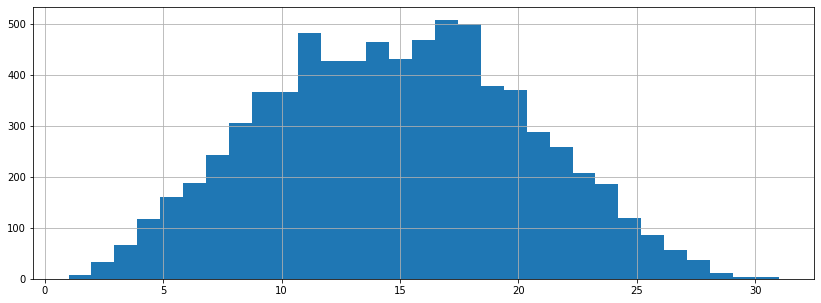

In [23]:
lengths=[len(t.split(' ')) for t in training_sentences]
plt.figure(figsize=(14,5))
plt.hist(lengths,bins=len(set(lengths)))
plt.grid()
plt.show()

In [24]:
#Defining a function that will help us in truncation and padding
sequences=tokenizer.texts_to_sequences(training_sentences)
train_sequence_padded=pad_sequences(sequences, truncating='post', padding='post', maxlen=29)
train_sequence_padded[3]

array([  1,  39,  13,  53, 236,  30, 599,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0], dtype=int32)

In [27]:
model=tf.keras.Sequential([
    tf.keras.layers.Embedding(1000,64,input_length=29),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), 
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 29, 64)            64000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 29, 128)          66048     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 175,489
Trainable params: 175,489
Non-tr

In [28]:
history=model.fit(train_sequence_padded,df_train.target,                 
                  epochs=20,batch_size=32,validation_split=0.15,
                  )

Epoch 1/20
201/201 [==============================] - 11s 27ms/step - loss: 0.5325 - accuracy: 0.7233 - val_loss: 0.4743 - val_accuracy: 0.7811
Epoch 2/20
201/201 [==============================] - 3s 15ms/step - loss: 0.4206 - accuracy: 0.8218 - val_loss: 0.4826 - val_accuracy: 0.7767
Epoch 3/20
201/201 [==============================] - 3s 15ms/step - loss: 0.3902 - accuracy: 0.8375 - val_loss: 0.4867 - val_accuracy: 0.7696
Epoch 4/20
201/201 [==============================] - 3s 15ms/step - loss: 0.3665 - accuracy: 0.8509 - val_loss: 0.5366 - val_accuracy: 0.7520
Epoch 5/20
201/201 [==============================] - 3s 15ms/step - loss: 0.3414 - accuracy: 0.8634 - val_loss: 0.5917 - val_accuracy: 0.7326
Epoch 6/20
201/201 [==============================] - 3s 15ms/step - loss: 0.3201 - accuracy: 0.8747 - val_loss: 0.5956 - val_accuracy: 0.7511
Epoch 7/20
201/201 [==============================] - 3s 15ms/step - loss: 0.3018 - accuracy: 0.8790 - val_loss: 0.6154 - val_accuracy: 0.753

In [29]:
sequences_test=tokenizer.texts_to_sequences(testing_sentences)
test_sequence_padded=pad_sequences(sequences_test, truncating='post', padding='post', maxlen=29)

In [30]:
model.evaluate(test_sequence_padded,df_sub.target)

102/102 [==============================] - 1s 9ms/step - loss: 2.8972 - accuracy: 0.6001


[2.8971846103668213, 0.600061297416687]

In [31]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

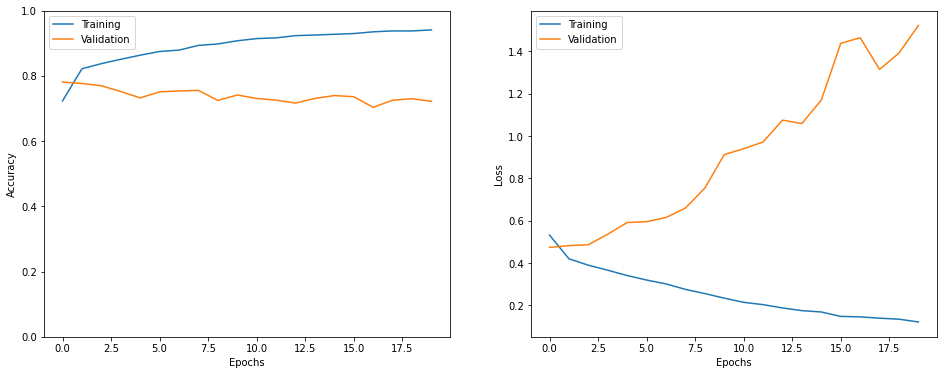

In [32]:
show_history(history)